<a href="https://colab.research.google.com/github/dtht2d/deep-learning/blob/main/codes/neural_network_fit/bodyfat__fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 30

Autosaving every 30 seconds


# **Objective**
---
- Create similarity **nftool** (MATLAB's Neural Network Toolbox) function in Python
- We have data from a health clinic and our goal is to design a neural network that can predict the percentage of body fat of a person, based on 13 anatomical measurements. The dataset contains information from 252 individuals, with measurements for each of the 13 variables, as well as their corresponding percentage of body fat. The objective is to train a neural network to predict body fat percentage based on the input variables.
- Observe the output by changing the training/validation/testing percentages and the number of neurons. 

## **1. Background**


### **Neural Network Fitting Algorithm**
A two-layer feed-forward network trained with Levenberg-Marquardt is a neural network architecture commonly used for solving regression problems. 

**Two-layer feed-forward neural network architecture:**
  - The information flows in a single direction from the input layer to the output layer.
  - There is one input layer, one output layer, and at least one hidden layer in between. The hidden layer(s) contain nodes that apply transformations to the input data, which are then fed forward to the output layer.

- **Levenberg-Marquardt algorithm:**
  - A popular optimization algorithm used to train neural networks by optimizing the weights and biases of the network.
  - It is a combination of two other optimization algorithms: the Gauss-Newton algorithm and the Gradient Descent algorithm
  - Particularly effective for training feed-forward neural networks with one or more hidden layers.
  - For mathemtical equations reference: http://web.eecs.utk.edu/~mjr/ECE505/Miscellaneous/levmar.pdf


## **2. Methods**


### Install packages


In [10]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = "/content/bodyfat.csv"

In [14]:
df = pd.read_csv(path)
print (df)

     Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  \
0     1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   
1     1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   
2     1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   
3     1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   
4     1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   
..       ...      ...  ...     ...     ...   ...    ...      ...    ...   
247   1.0736     11.0   70  134.25   67.00  34.9   89.2     83.6   88.8   
248   1.0236     33.6   72  201.00   69.75  40.9  108.5    105.0  104.5   
249   1.0328     29.3   72  186.75   66.00  38.9  111.1    111.5  101.7   
250   1.0399     26.0   72  190.75   70.50  38.9  108.3    101.3   97.8   
251   1.0271     31.9   74  207.50   70.00  40.8  112.4    108.5  107.1   

     Thigh  Knee  Ankle  Biceps  Forearm  Wrist  
0     59.0  37.3   21.9    32.0     27.4   17.1  

BodyFat" is located in the third column of the dataset, with an index of [2]. To prepare the data for training a neural network to predict body fat percentage, we need to select the input features (denoted as "X") that will be used to make the predictions. To do this, we should choose all the features in the dataset except for the "BodyFat" column. 

In [48]:
X = df.iloc[:, 2:].to_numpy()
y = df['BodyFat'].to_numpy()
y = np.reshape(y, (-1, 1)) 
#print X to check features number and y length
print(X.shape)
print(y.shape)

(252, 13)
(252, 1)


### **Create Levenberg-Marquardt class function - Python**

Keras does not have built in support for for the Levenberg-Marquardt algorithm so we have to rewrite Levenberg-Marquardt optimizer class function

In [94]:
from tensorflow.keras.optimizers import Optimizer

class LevenbergMarquardt(Optimizer):
    """Levenberg-Marquardt optimizer for TensorFlow.
    The Levenberg-Marquardt algorithm is a method for solving non-linear least squares problems.
    It is commonly used in machine learning for training neural networks.
    """
    def __init__(self, learning_rate=0.01, mu=0.1, eps=1e-8, name="LevenbergMarquardt", **kwargs):
        super().__init__(name=name, **kwargs)
        self._learning_rate = learning_rate
        self.mu = mu
        self.eps = eps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'g_squared')

    def _resource_apply_dense(self, grad, var):
        lr = self.learning_rate
        mu = self.mu
        eps = self.eps

        g_squared = self.get_slot(var, 'g_squared')
        g_squared_t = g_squared.assign_add(math_ops.square(grad))

        update = lr * grad / (g_squared_t + mu)
        var_update = var.assign_sub(update)

        return ops.group(*[var_update, g_squared_t])

    def _resource_apply_sparse(self, grad, var, indices):
        raise NotImplementedError("Sparse gradient updates are not supported.")

    def get_config(self):
        config = {
            'learning_rate': self._learning_rate,
            'mu': self.mu,
            'eps': self.eps,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


### **Define the neural network architecture**

- **First layer:** dense layer with 16 units, with input_shape set to (13,), which corresponds to the number of input features.
- **Second layer:** dense layer with 8 units and a relu activation function.
- **Third layer:** dense layer with 1 unit, which corresponds to the output of the neural network.

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=16, input_shape=(13,), activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# create an instance of the LevenbergMarquardt optimizer class
lm_optimizer = LevenbergMarquardt(learning_rate=0.01, mu=0.1, eps=1e-8)


- **keras.layers.Dense:** This specifies that we want to add a dense layer to the model.
- **units=16:** This sets the number of neurons in the layer to 16.
- **input_shape=(13,):** This specifies the shape of the input to the layer. In this case, the input X has shape (252, 13), then the input shape in the Dense layer should be (13,), which matches the number of features in the input data.
- **activation='relu':**This sets the activation function of the neurons in the layer to the rectified linear unit (ReLU) function. ReLU is a common activation function used in neural networks that is defined as max(0, x). It is often used in hidden layers because it is computationally efficient and helps prevent the vanishing gradient problem. 


Epoch 1/100
7/7 [==============================] - 1s 32ms/step - loss: 376.1912 - val_loss: 489.9270
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 376.1913 - val_loss: 489.9270
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 376.1912 - val_loss: 489.9270
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 376.1913 - val_loss: 489.9270
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 376.1912 - val_loss: 489.9270
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 376.1913 - val_loss: 489.9270
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 376.1913 - val_loss: 489.9270
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 376.1912 - val_loss: 489.9270
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 376.1912 - val_loss: 489.9270
Epoch 10/100
7/7 [==============================] - 0s 15ms/step - loss: 376.1912 - va

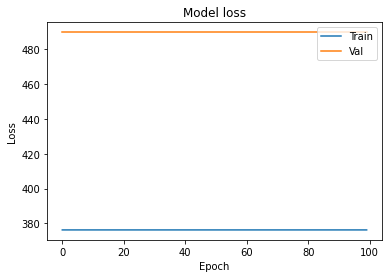

In [96]:


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()